In [1]:
from pathlib import Path

parent_dir = str(Path.cwd().parent)
%cd $parent_dir

/Users/tomtalpir/Random/pyERGM


In [2]:
from pyERGM.utils import *
from pyERGM.ergm import ERGM
from pyERGM.metrics import *

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


# Replicating the `Sampson` example from R's ERGM
The original R ERGM paper (Hunter et al. 2008) begins with a basic example of modeling Sampson's Monestary data, which consists of a directed network with $n=18$ nodes. This network models social interactions among a group of monks (See Sampson 1969 for more details). 

In the paper, An ERGM model is fit based on the Sampson network, using `num_of_edges` as its sole feature. The R fit yields a coefficient of `-0.9071582`, which is our aim.

In [3]:
# Matrix copied manually, TODO - Create a `data` dir in our project and save as a pickle or something.
sampson_matrix = np.array(
    [[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
     [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0],
     [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1],
     [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
     [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
     [1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
     [1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
     [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0],
     [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
     [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
     [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
     [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
     [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
     [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
     [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
     [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]]
)

W = sampson_matrix.copy()

num_edges_metric = NumberOfEdgesDirected()
indeg_metric = InDegree()

n_nodes = W.shape[0]
mc = MetricsCollection([num_edges_metric, indeg_metric], is_directed=True, n_nodes=n_nodes)
print(mc.num_of_features)

Removing the 0 feature of indegree to fix multi-collinearity
18


In [9]:
W = sampson_matrix.copy()

num_edges_metric = NumberOfEdgesDirected()
indeg_metric = InDegree()

n_nodes = W.shape[0]
mc = MetricsCollection([num_edges_metric, indeg_metric], is_directed=True, n_nodes=n_nodes, fix_collinearity=True)
print(mc.num_of_features)
Xs = np.zeros((n_nodes ** 2 - n_nodes, mc.num_of_features))
ys = np.zeros((n_nodes ** 2 - n_nodes))

x_idx = 0
for i, j in np.ndindex(W.shape):
    if i == j:
        continue
    y = W[i, j]

    calculated_score = 1
    W_plus = np.zeros(W.shape)
    W_plus[i, j] = 1
    calculated_score = mc.calc_change_scores(W_plus, (i, j))
    Xs[x_idx, :] = calculated_score
    ys[x_idx] = y
    x_idx += 1



HELLO
18


In [61]:
mc.num_of_features

18

In [10]:


from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, fit_intercept=False).fit(Xs, ys)
print(clf.coef_)


[[ 0.62570745 -0.79253663  0.6656238   0.19511052 -0.41062785  0.93944924
  -0.01557771  0.19511052  0.4202479   0.93944924  0.6656238  -0.2162774
   0.19511052 -0.01557771  0.6656238   0.6656238   0.93944924  0.6656238 ]]


HELLO
Initial thetas - [ 0.12449193  0.91197481  0.56927869 -0.18901041 -0.69607448  0.73046828
  0.06391445  0.28979104 -0.94822036  0.52686955  0.28002281  0.79258133
  0.05354835 -0.70934264  0.69812141  0.3454507   0.25566173 -0.32727934]
optimization started
Step 1 - lr: 9.0000000000, time from start: 0.17, window_grad: 9.39
Step 2 - lr: 8.1000000000, time from start: 0.32, window_grad: 8.16
Step 3 - lr: 7.2900000000, time from start: 0.47, window_grad: 6.85
Step 4 - lr: 6.5610000000, time from start: 0.63, window_grad: 5.57
Step 5 - lr: 5.9049000000, time from start: 0.78, window_grad: 4.61
Step 6 - lr: 5.3144100000, time from start: 0.94, window_grad: 3.98
Step 7 - lr: 4.7829690000, time from start: 1.11, window_grad: 3.45
Step 8 - lr: 4.3046721000, time from start: 1.28, window_grad: 3.05
Step 9 - lr: 3.8742048900, time from start: 1.43, window_grad: 2.75
Step 10 - lr: 3.4867844010, time from start: 1.60, window_grad: 2.49
Step 11 - lr: 3.1381059609, time from start: 1.75, wind

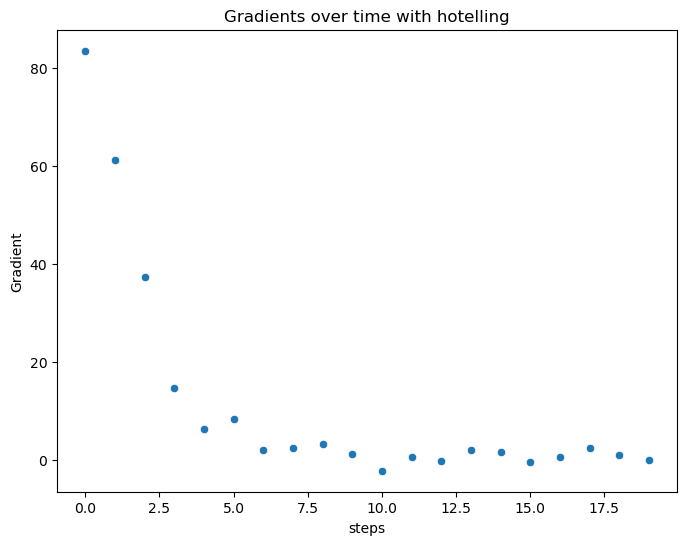

Fitted theta: [ 0.60592812 -0.28682912 -2.06952085 -1.44095707 -0.7281634  -2.52322612
 -1.20778167 -1.46366109 -1.73436601 -2.60748832 -2.15722909 -0.96003524
 -1.44535449 -1.21147927 -2.19686921 -2.13912151 -2.56424579 -2.135561  ]


In [12]:
n = sampson_matrix.shape[0]
is_directed = True

num_edges_metric = NumberOfEdgesDirected()
indeg_metric = InDegree()

fitted_model = ERGM(n, [num_edges_metric, indeg_metric], is_directed=is_directed, sample_size=2000, n_mcmc_steps=n)

convergence_criterion = "hotelling"
grads, hotelling = fitted_model.fit(sampson_matrix, lr=10, opt_steps=20,
                                    lr_decay_pct=0.1, steps_for_decay=1,
                                    sliding_grad_window_k=20, sample_pct_growth=0.05,
                                    convergence_criterion=convergence_criterion,
                                    optimization_method="newton_raphson",
                                    hotelling_confidence=0.95,
                                    cov_matrix_estimation_method="multivariate_initial_sequence",
                                    )

grads = [x[0] for x in grads]

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(grads, ax=ax)
ax.set(xlabel='steps', ylabel='Gradient')
ax.set_title(f"Gradients over time with {convergence_criterion}")
plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

Initial thetas - [0.46581701]
optimization started
Step 1 - lr: 0.0500000000, time from start: 0.04, sample_size: 500, sliding_grad_window_k: 20
	 Sample size increased at step 50 to 525
Step 51 - lr: 0.0450000000, time from start: 1.18, sample_size: 525, sliding_grad_window_k: 21
	 Sample size increased at step 100 to 551
Step 101 - lr: 0.0405000000, time from start: 2.50, sample_size: 551, sliding_grad_window_k: 23
Reached a confidence of 0.95 with the hotelling convergence test! DONE! 
hotelling - 0.0, hotelling_critical_value=0.003935730375712225


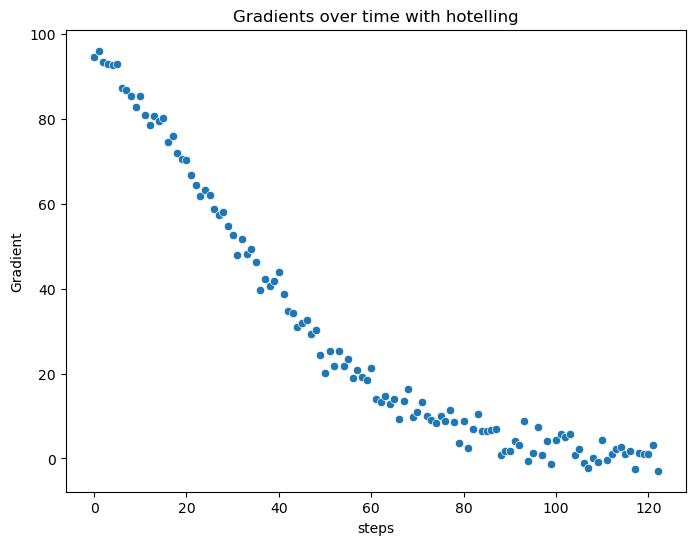

Fitted theta: [-0.88204551]


In [34]:
n = sampson_matrix.shape[0]
is_directed = True

number_of_edges_metric = NumberOfEdgesDirected() if is_directed else NumberOfEdgesUndirected()
fitted_model = ERGM(n, [number_of_edges_metric], is_directed=is_directed, sample_size=500, n_mcmc_steps=50)

convergence_criterion = "hotelling"
grads, hotelling = fitted_model.fit(sampson_matrix, lr=0.05, opt_steps=300,
                                    lr_decay_pct=0.1, steps_for_decay=50,
                                    sliding_grad_window_k=20, sample_pct_growth=0.05,
                                    convergence_criterion=convergence_criterion,
                                    optimization_method="newton_raphson",
                                    hotelling_confidence=0.95
                                    )

grads = [x[0] for x in grads]

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(grads, ax=ax)
ax.set(xlabel='steps', ylabel='Gradient')
ax.set_title(f"Gradients over time with {convergence_criterion}")
plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

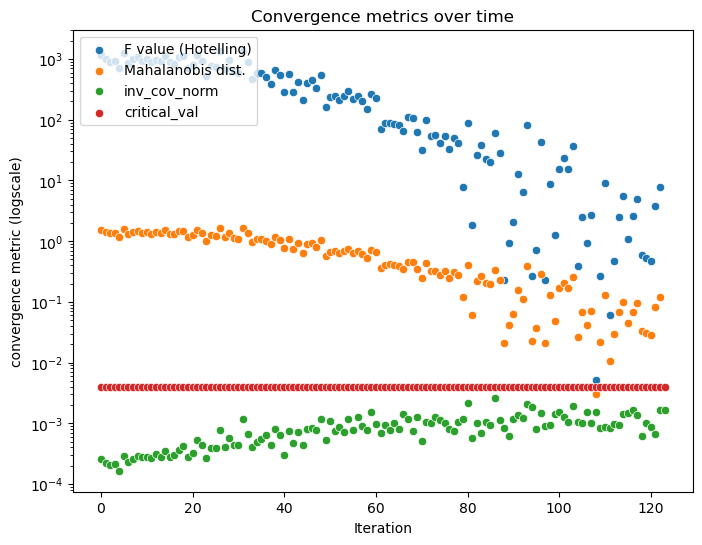

In [35]:
df = pd.DataFrame(hotelling)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(df["hotelling_F"])
# sns.scatterplot(df["hotelling_t"])
sns.scatterplot(df["dist"])
sns.scatterplot(df["inv_cov_norm"])
sns.scatterplot(df["critical_val"])

# sns.scatterplot(df["hessian_norm"])
ax.set_yscale("log")

ax.legend(["F value (Hotelling)", "Mahalanobis dist.", "inv_cov_norm", "critical_val", ], loc="upper left")
ax.set(xlabel='Iteration', ylabel='convergence metric (logscale)')
ax.set_title("Convergence metrics over time")

plt.show()


As we can see, our model reaches a theta that is extremely close to the actual R result.

In [7]:
min(hotelling)

3.6470473599830022

10847918.021540165

## Now test a model with TotalReciprocity + NumberOfEdges

Initial thetas - [ 0.57095926 -0.14783974]
optimization started
Step 1 - lr: 0.0500000000, time from start: 0.04, sample_size: 500, sliding_grad_window_k: 20
	 Sample size increased at step 50 to 525
Step 51 - lr: 0.0450000000, time from start: 1.35, sample_size: 525, sliding_grad_window_k: 21
	 Sample size increased at step 100 to 551
Step 101 - lr: 0.0405000000, time from start: 2.72, sample_size: 551, sliding_grad_window_k: 23
	 Sample size increased at step 150 to 578
Step 151 - lr: 0.0364500000, time from start: 4.13, sample_size: 578, sliding_grad_window_k: 25
	 Sample size increased at step 200 to 606
Step 201 - lr: 0.0328050000, time from start: 5.59, sample_size: 606, sliding_grad_window_k: 27
Reached a confidence of 0.95 with the hotelling convergence test! DONE! 
hotelling - 0.042725689608504966, hotelling_critical_value=0.05129765059783868


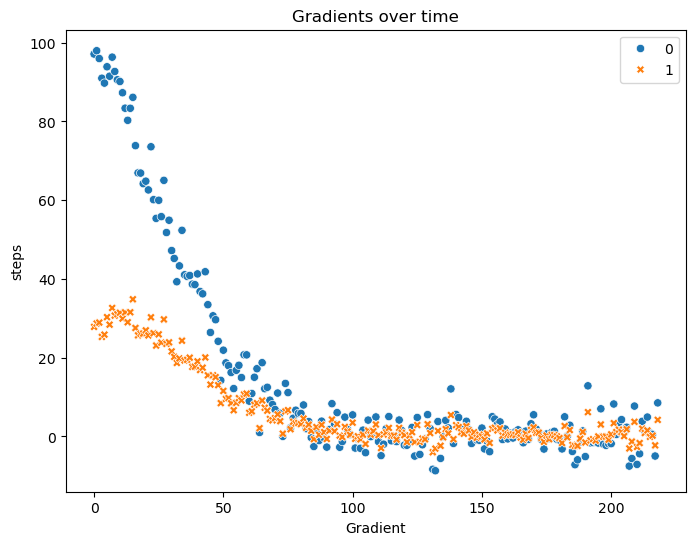

Fitted theta: [-1.7869004   2.37748828]


In [30]:
n = sampson_matrix.shape[0]
is_directed = True

number_of_edges_metric = NumberOfEdgesDirected() if is_directed else NumberOfEdgesUndirected()

estimated_p_seed = np.sum(sampson_matrix) / (n * (n - 1))

metrics = [number_of_edges_metric, TotalReciprocity()]
fitted_model = ERGM(n, metrics, is_directed=is_directed, sample_size=500, n_mcmc_steps=20,
                    seed_MCMC_proba=estimated_p_seed)

# convergence_criterion = "zero_grad_norm"
convergence_criterion = "hotelling"
grads, hotelling = fitted_model.fit(sampson_matrix, lr=0.05, opt_steps=500,
                                    lr_decay_pct=0.1, steps_for_decay=50,
                                    sliding_grad_window_k=20, sample_pct_growth=0.05,
                                    convergence_criterion=convergence_criterion,
                                    optimization_method="newton_raphson",
                                    hotelling_confidence=0.95
                                    )

# grads, _ = fitted_model.fit(sampson_matrix, lr=1, opt_steps=400, sliding_grad_window_k=20, sample_pct_growth=0.05, lr_decay_pct=0.1, steps_for_decay=10)


fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(grads, ax=ax)
ax.set(xlabel='Gradient', ylabel='steps')
ax.set_title("Gradients over time")

plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

#### Took a while (~1 minute), but results are pretty close!
True results in R -
* $\theta_1 = -1.7625$
* $\theta_2 = 2.3132$

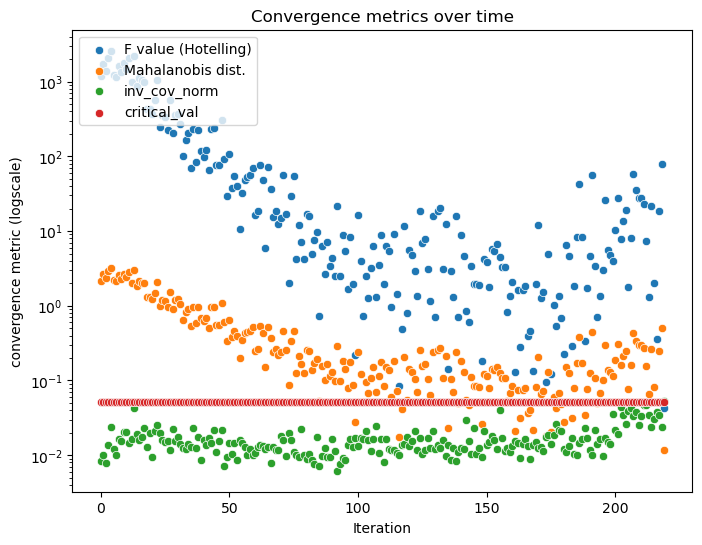

In [31]:
df = pd.DataFrame(hotelling)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(df["hotelling_F"])
# sns.scatterplot(df["hotelling_t"])
sns.scatterplot(df["dist"])
sns.scatterplot(df["inv_cov_norm"])
sns.scatterplot(df["critical_val"])

# sns.scatterplot(df["hessian_norm"])
ax.set_yscale("log")

ax.legend(["F value (Hotelling)", "Mahalanobis dist.", "inv_cov_norm", "critical_val", ], loc="upper left")
ax.set(xlabel='Iteration', ylabel='convergence metric (logscale)')
ax.set_title("Convergence metrics over time")

plt.show()


## And finally we test the full $p_1$ model

Initial thetas - [ 0.28827645 -0.30684158  0.479341    0.17185113  0.49247225 -0.45207639
  0.06836346  0.68088155  0.07391247  0.26471403 -0.39020924 -0.55934248
 -0.21499352 -0.93504194  0.11415357 -0.47267348  0.57275427 -0.02934673
 -0.81718943 -0.54912015  0.83508081  0.55931227  0.37649883  0.08358955
 -0.47420078  0.1213598   0.74802039 -0.2289383  -0.6682042  -0.44921032
  0.7469247   0.60096492 -0.77580828  0.18554729  0.40813755 -0.2752307 ]
optimization started
Step 1 - lr: 9.9000000000, time from start: 14.86, window_grad: 6.69
Step 2 - lr: 9.8010000000, time from start: 30.54, window_grad: 5.32
Step 3 - lr: 9.7029900000, time from start: 47.34, window_grad: 4.53
Step 4 - lr: 9.6059601000, time from start: 64.55, window_grad: 3.98
Step 5 - lr: 9.5099004990, time from start: 81.13, window_grad: 3.51
Step 6 - lr: 9.4148014940, time from start: 101.16, window_grad: 3.20
Step 7 - lr: 9.3206534791, time from start: 118.72, window_grad: 2.93
Step 8 - lr: 9.2274469443, time from s

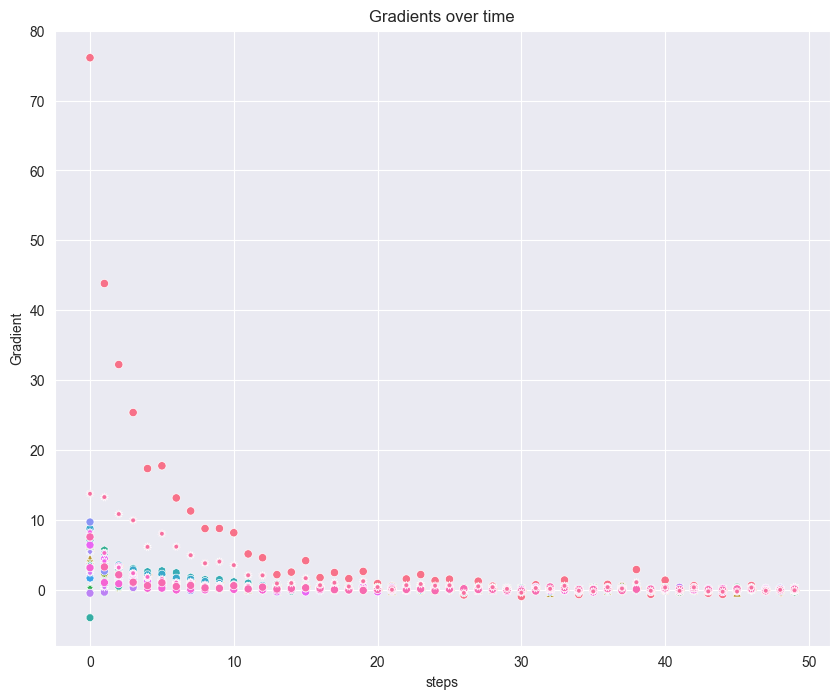

Fitted theta: [-1.20812908 -0.21138169  1.47926585  0.37185598  0.16285013  1.23870782
  0.63485979  1.38347613  0.66494617  2.09815172  1.47364245 -0.08315995
 -0.19372719  0.63144474  1.90713567  1.45837586  1.2814594   1.88450798
 -0.16473678 -3.03211957 -1.71493697 -0.82018744 -3.41267064 -1.58506585
 -2.26114048 -2.19190355 -3.8950203  -3.03192524 -0.97244069 -1.47047983
 -1.60431408 -3.29974934 -3.01420367 -3.42519411 -3.30820354  3.67288198]


In [10]:
n = sampson_matrix.shape[0]
is_directed = True

estimated_p_seed = np.sum(sampson_matrix) / (n * (n - 1))

metrics = [NumberOfEdgesDirected(), OutDegree(), InDegree(), TotalReciprocity()]

fitted_model = ERGM(n, metrics, is_directed=is_directed, sample_size=15000, n_mcmc_steps=20,
                    seed_MCMC_proba=estimated_p_seed)

# convergence_criterion = "zero_grad_norm"
convergence_criterion = "hotelling"
covariance_estimation_method = "multivariate_initial_sequence"

hotelling_conf = 0.9
grads, hotelling = fitted_model.fit(sampson_matrix, lr=10, opt_steps=50,
                                    lr_decay_pct=0.01, steps_for_decay=1,
                                    sliding_grad_window_k=20, sample_pct_growth=0.05,
                                    convergence_criterion=convergence_criterion,
                                    optimization_method="newton_raphson",
                                    hotelling_confidence=hotelling_conf,
                                    cov_matrix_estimation_method=covariance_estimation_method
                                    )

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(grads, ax=ax, legend=False)
ax.set(xlabel='steps', ylabel='Gradient')
ax.set_title("Gradients over time")
plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

In [19]:
df["hotelling_F"].min()

np.float64(11.362362711031647)

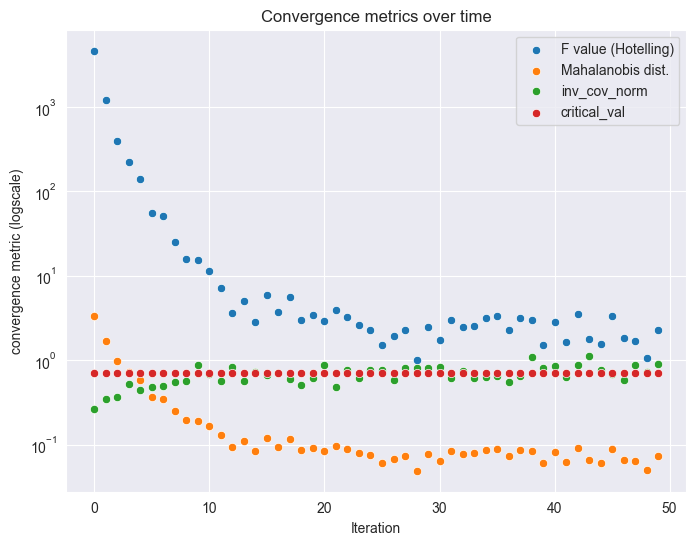

In [11]:
df = pd.DataFrame(hotelling)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(df["hotelling_F"])
# sns.scatterplot(df["hotelling_t"])
sns.scatterplot(df["dist"])
sns.scatterplot(df["inv_cov_norm"])
sns.scatterplot(df["critical_val"])

# sns.scatterplot(df["hessian_norm"])
ax.set_yscale("log")

ax.legend(["F value (Hotelling)", "Mahalanobis dist.", "inv_cov_norm", "critical_val", ], loc="upper right")
ax.set(xlabel='Iteration', ylabel='convergence metric (logscale)')
ax.set_title("Convergence metrics over time")

plt.show()


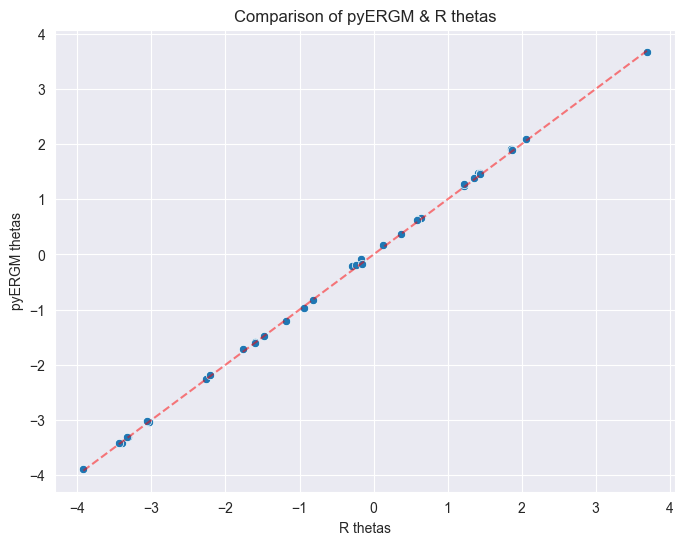

In [12]:
true_values = {"edges": -1.1761, "sender2": -0.2945, "sender3": 1.4141, "sender4": 0.3662, "sender5": 0.1315,
               "sender6": 1.2148, "sender7": 0.6055,
               "sender8": 1.3609, "sender9": 0.6402, "sender10": 2.0639, "sender11": 1.4355, "sender12": -0.1681,
               "sender13": -0.2322, "sender14": 0.5841, "sender15": 1.8600,
               "sender16": 1.4317, "sender17": 1.2211, "sender18": 1.8724, "receiver2": -0.1522, "receiver3": -3.0453,
               "receiver4": -1.7596, "receiver5": -0.8198, "receiver6": -3.3922,
               "receiver7": -1.6074, "receiver8": -2.2656, "receiver9": -2.2069, "receiver10": -3.9189,
               "receiver11": -3.0257, "receiver12": -0.9457, "receiver13": -1.4749, "receiver14": -1.5950,
               "receiver15": -3.3147, "receiver16": -3.0567, "receiver17": -3.4436, "receiver18": -3.3239,
               "mutual": 3.6918
               }

true_predictions = np.array(list(true_values.values()))
fitted_thetas = fitted_model._thetas

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=true_predictions, y=fitted_thetas)

min_x = min(min(true_predictions), min(fitted_thetas))
max_x = max(max(true_predictions), max(fitted_thetas))

sns.lineplot(x=[min_x, max_x], y=[min_x, max_x], color="red", linestyle="--", alpha=0.5)
ax.set(xlabel='R thetas', ylabel='pyERGM thetas')
ax.set_title("Comparison of pyERGM & R thetas")
plt.show()


<Axes: ylabel='critical_val'>

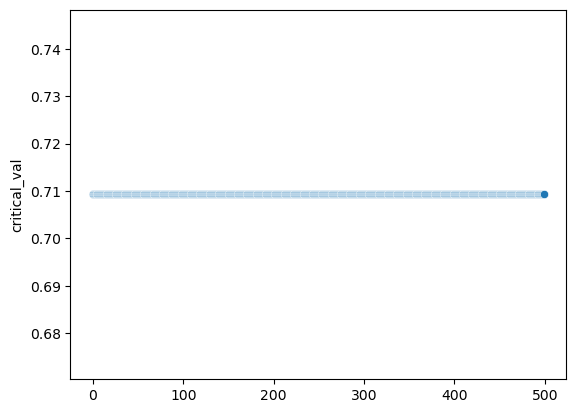

In [40]:
sns.scatterplot(df["critical_val"])

In [2]:
from pathlib import Path

parent_dir = str(Path.cwd().parent)
%cd $parent_dir

from utils import *
from ergm import ERGM
from metrics import *

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

/Users/tomtalpir/Random/pyERGM


Initial thetas - [ 0.83664237  0.7971601   0.71355013 -0.70150711 -0.08863087  0.39752971
  0.45965323  0.5268454  -0.87182557  0.79399886  0.23761249  0.74566616
 -0.7558319   0.56699397 -0.18879653 -0.76287328  0.44788555  0.14780879
  0.00852046 -0.01950427 -0.82083899 -0.11045728 -0.78492424 -0.1647573
  0.80255844 -0.51556553  0.65143873 -0.00780344  0.10958703  0.04054065
  0.83489826  0.82348079  0.51881712  0.05193168  0.7165471   0.48380242
  0.5945284  -0.44380219  0.91365705  0.86222071  0.32777885  0.32635926
  0.40770018  0.03445093 -0.15512978  0.92331482  0.15100117  0.13047354
  0.15195707  0.84630189  0.6550905  -0.62022841 -0.58629748  0.84028272
 -0.74871517  0.8073619  -0.407032   -0.17344516 -0.17786724  0.26590094
  0.26465457  0.66370602]
optimization started
Step 1 - lr: 20.0000000, time from start: 3.60, window_grad: 38.59
Step 2 - lr: 18.0000000, time from start: 7.04, window_grad: 28.51
Step 3 - lr: 16.2000000, time from start: 10.48, window_grad: 23.30
Step 

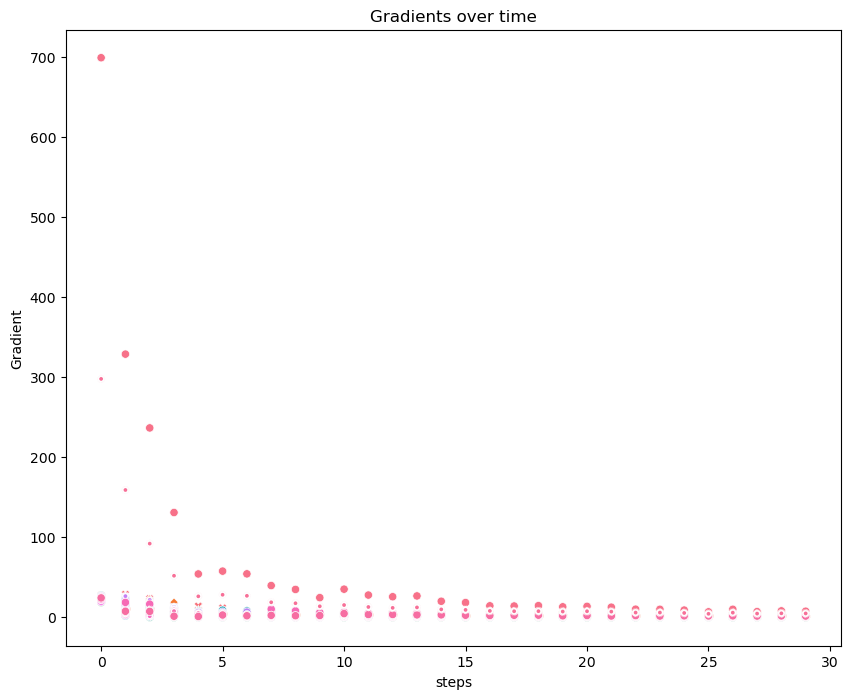

Fitted theta: [-7.71124409  0.18800035 -0.69241473  0.52462328  2.52061099  3.57694801
  0.81009498  0.49454871  2.45750057 -1.99473282  1.09464646 -0.85996151
 -6.90204069 -2.3197971   2.07109566  0.48060222 -0.30734905  0.70791046
  0.76349442 -1.63252462  0.21212069  0.41769905  2.94547924 -0.07916206
  2.66026459 -6.52615349 -5.18600191 -2.46202686 -0.37610026  2.41990724
 -1.06623659  2.58647251  0.58791289  1.91994352  0.82394606 -0.99721276
  2.56279809 -0.28425532 -0.96866768 -1.39478783 -5.21938962  3.4921185
 -2.40955599 -4.14307727  0.1197277   2.45619593  2.15563975 -2.07766212
  0.52383666  2.99158714 -3.80467896  1.3742861  -0.43464965  2.30638459
 -5.22939229  3.49732824 -2.42173005 -2.94093968  2.39054281 -1.39286365
  3.16735215  7.53755356]


In [11]:
gals_data = pd.read_csv("./connectome_data.csv")
gals_data = gals_data.drop("Unnamed: 0", axis=1)

W = gals_data.values

W = W[:30, :30]

n = W.shape[0]
is_directed = True

estimated_p_seed = np.sum(W) / (n * (n - 1))

# metrics = [NumberOfEdgesDirected(), TotalReciprocity()]
metrics = [NumberOfEdgesDirected(), OutDegree(), InDegree(), TotalReciprocity()]

fitted_model = ERGM(n, metrics, is_directed=is_directed, sample_size=10000, n_mcmc_steps=n,
                    seed_MCMC_proba=estimated_p_seed,
                    use_sparse_matrix=False)

# # convergence_criterion = "zero_grad_norm"
convergence_criterion = "hotelling"

hotelling_conf = 0.9
grads, hotelling = fitted_model.fit(W, lr=20, opt_steps=30,
                                    lr_decay_pct=0.1, steps_for_decay=1,
                                    sliding_grad_window_k=5, sample_pct_growth=0.05,
                                    convergence_criterion=convergence_criterion,
                                    optimization_method="newton_raphson",
                                    hotelling_confidence=hotelling_conf,
                                    cov_matrix_estimation_method="batch",
                                    # cov_matrix_estimation_method="multivariate_initial_sequence",
                                    mcmc_burn_in=0,
                                    mcmc_steps_per_sample=50,
                                    )

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(grads, ax=ax, legend=False)
ax.set(xlabel='steps', ylabel='Gradient')
ax.set_title("Gradients over time")
plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

In [7]:
df

,dist,hotelling_F,critical_val,inv_cov_norm,inv_hessian_norm
0,1.511810,11426.702938,0.105362,0.000254,0.016926
1,1.470946,10817.329151,0.105362,0.000262,0.013969
2,1.132893,6416.588952,0.105362,0.000124,0.016196
3,1.075460,5782.491057,0.105362,0.000102,0.012729
4,1.230048,7564.338370,0.105362,0.000114,0.014183
...,...,...,...,...,...
95,1.257223,7902.263932,0.105362,0.000138,0.012573
96,1.173751,6887.772751,0.105362,0.000151,0.015951
97,1.407260,9900.915087,0.105362,0.000237,0.016778
98,1.376713,9475.745038,0.105362,0.000194,0.013799


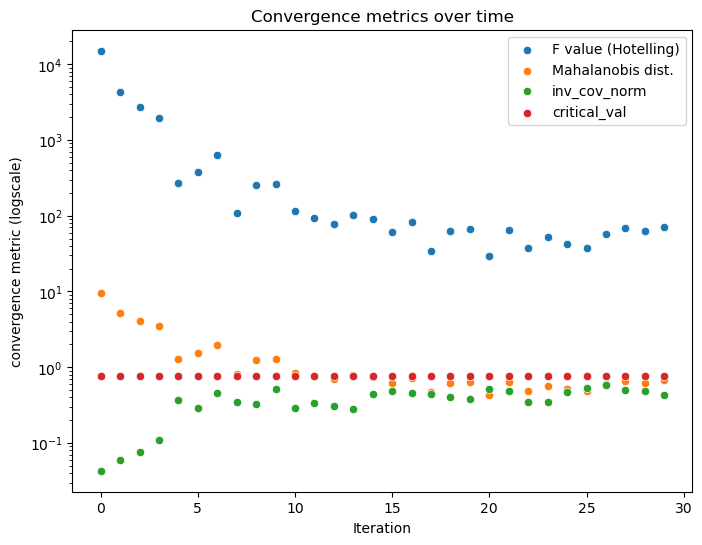

In [12]:
df = pd.DataFrame(hotelling)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(df["hotelling_F"])
# sns.scatterplot(df["hotelling_t"])
sns.scatterplot(df["dist"])
sns.scatterplot(df["inv_cov_norm"])
sns.scatterplot(df["critical_val"])

# sns.scatterplot(df["inv_hessian_norm"])
ax.set_yscale("log")

ax.legend(["F value (Hotelling)", "Mahalanobis dist.", "inv_cov_norm", "critical_val", "inv_hessian_norm"],
          loc="upper right")
ax.set(xlabel='Iteration', ylabel='convergence metric (logscale)')
ax.set_title("Convergence metrics over time")

plt.show()


In [10]:
df["hotelling_F"].min() - df["critical_val"].iloc[0]

13.577978681405007

<Axes: >

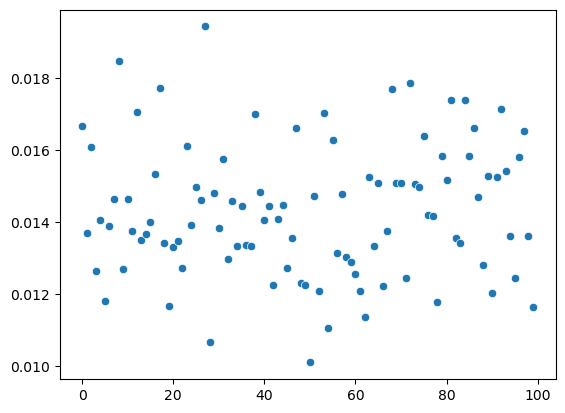

In [12]:
sns.scatterplot(df["inv_hessian_norm"] - df["inv_cov_norm"])

# Testing convergence with the sampson dataset

## This is for testing from mple

In [8]:
metrics = [NumberOfEdgesDirected(), OutDegree(), InDegree()]
# metrics = [NumberOfEdgesDirected(), OutDegree(), InDegree(), TotalReciprocity()]


n_nodes = W.shape[0]

mcmc_sample_size = 1000

mple_model = ERGM(n_nodes, metrics, is_directed=True)
mple_model.fit(W, 
        opt_steps=0, steps_for_decay=1, lr=1, mple_lr=0.5, 
          mcmc_burn_in=0,
          mcmc_steps_per_sample=50000,
          mcmc_sample_size=mcmc_sample_size
          )

Removing the 0 feature of outdegree to fix multi-collinearity
Removing the 0 feature of indegree to fix multi-collinearity
MPLE with lr 0.5
Logistic regression optimization started
Iteration 0, log-likelihood: -439.3347757659593, time from start: 0.14117841701954603 seconds, lr: 0.5
Iteration 1, log-likelihood: -173.84943753449895, time from start: 0.18999016704037786 seconds, lr: 0.5
Iteration 2, log-likelihood: -166.77828661344665, time from start: 0.2733507079537958 seconds, lr: 0.5
Iteration 3, log-likelihood: -164.63985357052138, time from start: 0.29484758293256164 seconds, lr: 0.5
Iteration 4, log-likelihood: -163.98141615436944, time from start: 0.30014104186557233 seconds, lr: 0.5
Iteration 5, log-likelihood: -163.7887218710238, time from start: 0.30937941698357463 seconds, lr: 0.5
Iteration 6, log-likelihood: -163.73536774413077, time from start: 0.3118197079747915 seconds, lr: 0.5
Iteration 7, log-likelihood: -163.7212058497192, time from start: 0.31317520793527365 seconds, 

(None, None)

### TODO - 
Run this with the different parameters, and plot the empirical threshold for the different params

In [17]:
sample_from_mple = mple_model.generate_networks_for_sample(sample_size=1000,
                                        sampling_method="exact")


observed_features = mple_model._metrics_collection.calculate_statistics(W)
num_subsamples_data = 1000 # Try also for [10, 100, 1k, 10k]
data_splitting_method = "uniform"

bootstrapped_features = mple_model._metrics_collection.bootstrap_observed_features(W,
                                                                num_subsamples=num_subsamples_data,
                                                                splitting_method=data_splitting_method)

observed_covariance = covariance_matrix_estimation(bootstrapped_features,
                                    bootstrapped_features.mean(axis=1), method='naive')
inv_observed_covariance = np.linalg.inv(observed_covariance)

num_of_samples_per_subsample = 100 # Try also for [10, 100, 1k, 10k]
num_model_sub_samples = 50 # Try also for [10, 50, 100]
model_subsample_size =  int(num_of_samples_per_subsample)
mahalanobis_dists = np.zeros(num_model_sub_samples)
sub_sample_indices = np.random.choice(np.arange(mcmc_sample_size),
                                        size=num_model_sub_samples * model_subsample_size).reshape(
    (num_model_sub_samples, model_subsample_size))
for cur_subsam_idx in range(num_model_sub_samples):
    cur_sub_sample = sample_from_mple[:, :, sub_sample_indices[cur_subsam_idx]]
    cur_subsample_features_mean = np.mean(
        mple_model._metrics_collection.calculate_sample_statistics(cur_sub_sample), axis=1)
    mahalanobis_dists[cur_subsam_idx] = mahalanobis(observed_features, cur_subsample_features_mean,
                                                    inv_observed_covariance)
bootstrap_convergence_confidence = 0.95
bootstrap_convergence_num_stds_away_thr = 1
empirical_threshold = np.quantile(mahalanobis_dists, bootstrap_convergence_confidence)
if bootstrap_convergence_num_stds_away_thr > empirical_threshold:
    print(f"Reached a confidence of {bootstrap_convergence_confidence} with the bootstrap convergence "
            f"test! The model is likely to be up to {bootstrap_convergence_num_stds_away_thr} stds from "
            f"the data, according to the estimated data variability DONE! ")


In [24]:
observed_features = mcmle_model._metrics_collection.calculate_statistics(W)

starting_network = mcmle_model.generate_networks_for_sample(sample_size=1, sampling_method="exact")
starting_network = starting_network[:, :, 0]

networks_for_sample = mcmle_model.generate_networks_for_sample(sample_size=mcmc_sample_size,
                                                               seed_network=starting_network,
                                                               burn_in=0,
                                                               mcmc_steps_per_sample=n_nodes**2,
                                                               )

num_subsamples_data = 1000
data_splitting_method = "uniform"

bootstrapped_features = mcmle_model._metrics_collection.bootstrap_observed_features(W,
                                                                num_subsamples=num_subsamples_data,
                                                                splitting_method=data_splitting_method)
observed_covariance = covariance_matrix_estimation(bootstrapped_features,
                                    bootstrapped_features.mean(axis=1), method='naive')
inv_observed_covariance = np.linalg.inv(observed_covariance)

num_model_sub_samples =  50
model_subsample_size =  int(mcmc_sample_size * 0.2)
mahalanobis_dists = np.zeros(num_model_sub_samples)
sub_sample_indices = np.random.choice(np.arange(mcmc_sample_size),
                                        size=num_model_sub_samples * model_subsample_size).reshape(
    (num_model_sub_samples, model_subsample_size))
for cur_subsam_idx in range(num_model_sub_samples):
    cur_sub_sample = networks_for_sample[:, :, sub_sample_indices[cur_subsam_idx]]
    cur_subsample_features_mean = np.mean(
        mcmle_model._metrics_collection.calculate_sample_statistics(cur_sub_sample), axis=1)
    mahalanobis_dists[cur_subsam_idx] = mahalanobis(observed_features, cur_subsample_features_mean,
                                                    inv_observed_covariance)
bootstrap_convergence_confidence = 0.95
bootstrap_convergence_num_stds_away_thr = 1
empirical_threshold = np.quantile(mahalanobis_dists, bootstrap_convergence_confidence)
if bootstrap_convergence_num_stds_away_thr > empirical_threshold:
    print(f"Reached a confidence of {bootstrap_convergence_confidence} with the bootstrap convergence "
            f"test! The model is likely to be up to {bootstrap_convergence_num_stds_away_thr} stds from "
            f"the data, according to the estimated data variability DONE! ")


Sampled 100/1000 networks, time taken: 0.3788609504699707
Sampled 200/1000 networks, time taken: 0.7760710716247559
Sampled 300/1000 networks, time taken: 1.1872639656066895
Sampled 400/1000 networks, time taken: 1.5670580863952637
Sampled 500/1000 networks, time taken: 1.951512098312378
Sampled 600/1000 networks, time taken: 2.3378632068634033
Sampled 700/1000 networks, time taken: 2.7213540077209473
Sampled 800/1000 networks, time taken: 3.1958141326904297
Sampled 900/1000 networks, time taken: 3.5832297801971436
Sampled 1000/1000 networks, time taken: 3.9682111740112305
Reached a confidence of 0.95 with the bootstrap convergence test! The model is likely to be up to 1 stds from the data, according to the estimated data variability DONE! 


## And this is for an mcmc example

In [21]:
# metrics = [NumberOfEdgesDirected(), OutDegree(), InDegree()]
metrics = [NumberOfEdgesDirected(), OutDegree(), InDegree(), TotalReciprocity()]

n_nodes = W.shape[0]

estimated_p_seed = np.sum(W) / (n_nodes * (n_nodes - 1))

mcmc_sample_size = 5000

mcmle_model = ERGM(n_nodes, metrics, is_directed=True, seed_MCMC_proba=estimated_p_seed)
returned_params = mcmle_model.fit(W, 
        opt_steps=5, steps_for_decay=1, lr=0.5, mple_lr=0.5, 
        # no_mple=True, theta_init_method="uniform", 
        convergence_criterion="observed_bootstrap",

          mcmc_burn_in=10000,
          mcmc_steps_per_sample=n_nodes**2,
          mcmc_sample_size=mcmc_sample_size,
          num_model_sub_samples=100,
          model_subsample_size=int(mcmc_sample_size * 0.2),
          bootstrap_convergence_confidence=0.99,
          bootstrap_convergence_num_stds_away_thr=1
          )

Removing the 0 feature of outdegree to fix multi-collinearity
Removing the 0 feature of indegree to fix multi-collinearity
MPLE with lr 0.5
Logistic regression optimization started
Iteration 0, log-likelihood: -391.9970912777001, time from start: 0.17744462518021464 seconds, lr: 0.5
Iteration 1, log-likelihood: -145.5040226520039, time from start: 0.26724166609346867 seconds, lr: 0.5
Iteration 2, log-likelihood: -128.49921569919698, time from start: 0.2915770001709461 seconds, lr: 0.5
Iteration 3, log-likelihood: -121.000608455605, time from start: 0.32417754107154906 seconds, lr: 0.5
Iteration 4, log-likelihood: -117.66434285358218, time from start: 0.34933516616001725 seconds, lr: 0.5
Iteration 5, log-likelihood: -116.29812260984792, time from start: 0.36880916613154113 seconds, lr: 0.5
Iteration 6, log-likelihood: -115.80255283665794, time from start: 0.3889405829831958 seconds, lr: 0.5
Iteration 7, log-likelihood: -115.6434088725892, time from start: 0.44523725006729364 seconds, lr

In [12]:
returned_params[-1]

[0.8504815715960989]

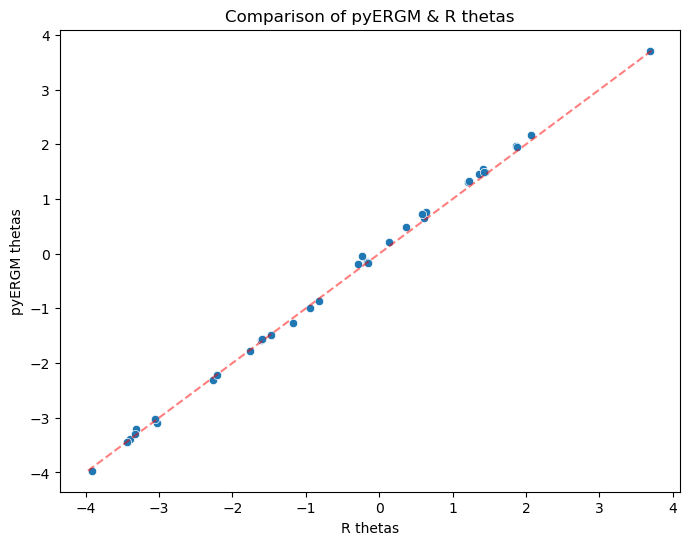

In [22]:
true_values = {"edges": -1.1761, "sender2": -0.2945, "sender3": 1.4141, "sender4": 0.3662, "sender5": 0.1315,
               "sender6": 1.2148, "sender7": 0.6055,
               "sender8": 1.3609, "sender9": 0.6402, "sender10": 2.0639, "sender11": 1.4355, "sender12": -0.1681,
               "sender13": -0.2322, "sender14": 0.5841, "sender15": 1.8600,
               "sender16": 1.4317, "sender17": 1.2211, "sender18": 1.8724, "receiver2": -0.1522, "receiver3": -3.0453,
               "receiver4": -1.7596, "receiver5": -0.8198, "receiver6": -3.3922,
               "receiver7": -1.6074, "receiver8": -2.2656, "receiver9": -2.2069, "receiver10": -3.9189,
               "receiver11": -3.0257, "receiver12": -0.9457, "receiver13": -1.4749, "receiver14": -1.5950,
               "receiver15": -3.3147, "receiver16": -3.0567, "receiver17": -3.4436, "receiver18": -3.3239,
               "mutual": 3.6918
               }

true_predictions = np.array(list(true_values.values()))
fitted_thetas = mcmle_model._thetas

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=true_predictions, y=fitted_thetas)

min_x = min(min(true_predictions), min(fitted_thetas))
max_x = max(max(true_predictions), max(fitted_thetas))

sns.lineplot(x=[min_x, max_x], y=[min_x, max_x], color="red", linestyle="--", alpha=0.5)
ax.set(xlabel='R thetas', ylabel='pyERGM thetas')
ax.set_title("Comparison of pyERGM & R thetas")
plt.show()


{'num_edges_directed': 1.0830302563408827,
 'outdegree_2': -0.2974588739722166,
 'outdegree_3': -0.43574741535024314,
 'outdegree_4': -0.7217537706088066,
 'outdegree_5': -0.3428969815745873,
 'outdegree_6': -0.7705152529925025,
 'outdegree_7': -0.37553574547540175,
 'outdegree_8': -0.08649408875923563,
 'outdegree_9': -0.7467442043801437,
 'outdegree_10': -0.15381454160289504,
 'outdegree_11': -0.42948110593659283,
 'outdegree_12': -0.6832939418011337,
 'outdegree_13': -1.1074122702202764,
 'outdegree_14': -0.3795901751013242,
 'outdegree_15': -0.12720890822018857,
 'outdegree_16': -0.4427404002920216,
 'outdegree_17': -0.7901883594799912,
 'outdegree_18': -0.14456401094513388,
 'indegree_2': -0.25718909356895053,
 'indegree_3': -2.1568631177631916,
 'indegree_4': -1.5150648949213663,
 'indegree_5': -0.7466151511375229,
 'indegree_6': -2.612987792163648,
 'indegree_7': -1.236340758626272,
 'indegree_8': -1.4770447029041223,
 'indegree_9': -1.8273669059737845,
 'indegree_10': -2.576797